## Implementation of a Convolutional Auto-Encoder to extract latent representations of climate fields 

### What this notebook is about ?

This Jupyter notebook illustrates the use of a **Convolutional Auto-Encoder** to learn latent, non linear representations of climate fields

### What is the context ?

Part of the code illustrated here has been developed as part of a project aiming at developing better (more accurate) and more locally relevant (downscaled) seasonal climate forecasts
for New Zealand / Aotearoa. 

The idea pertaining to this particular component of the project is to train **Auto-Encoders** on General Circulation Models outputs 
(in this particular case the ECMWF seasonal climate re-forecasts), and 're-cycle' the lower layers (the *encoding* layers) into a another Deep Neural Network, where the upper layers (decoding layers) are being replaced by a set of Dense layers, with the output (target) being either observed regional time-series of e.g. seasonal temperature or rainfall anomalies, or with Convolutional Layers if the target is a gridded observational dataset such as the VCSN. This is essentially a form of unsupervised pre-training*, where we make the most of the fact (see below) that the GCM forecasts are ensemble forecasts (i.e. contain several members). 

* [Erhan, D., Y. Bengio, A. Courville, P.-A. Manzagol, P. Vincent, and S. Bengio, Why Does Unsupervised Pre-training Help Deep Learning? 36](https://jmlr.org/papers/volume11/erhan10a/erhan10a.pdf)

### What are auto-encoders ?

[Auto-Encoders](https://en.wikipedia.org/wiki/Autoencoder) (AE) are a type of Neural Networks that - in a nustchell - learn to **reproduce their inputs** ... at first sight that doesnt look like a very useful thing to do, but the twist is that the hidden layers have a lower dimensionality than the inputs, so AEs effectively learn the *identity function* under constraints, and are forced to learn the most important features in the input data. An AE is always composed of 2 parts: An *encoder*, that converts the inputs to a latent representation, and a *decoder* that converts the internal representation to the outputs (i.e. generate *reconstructions*). In the context of this project AEs could have advantages compared to more traditional dimensionality reduction methods such as Principal Component Analysis (PCA) because they can learn non-linear features, and for the reasons explained above (training an AE can be the first step into building another Neural Network). 

### What are Convolutional Auto-Encoders ?

Convolutional Auto-encoders use **Convolutional layers** in both the encoder and decoder components. It is beyond the scope of this Notebook to give an introduction to Convolutional Neural Networks, a couple of very useful resources are: 

1) [Goodfellow, I., Y. Bengio, and A. Courville, 2016: Deep Learning. MIT Press](https://www.deeplearningbook.org), available online, see notably [Chapter 9](https://www.deeplearningbook.org/contents/convnets.html)

2) [Zhang, A., Z. C. Lipton, M. Li, and A. J. Smola, 2020: Dive into Deep Learning](https://d2l.ai/index.html), a very excellent online, interactive  book with code, math, and discussions, providing NumPy/MXNet, PyTorch, and TensorFlow implementations. See in particular Chapters 6 and 7. 

In short, Convolutional Neural Networks are commonly used in Computer Vision as they are able to capture **spatial dependency** in input images. In the context of climate fields and applied as part of an Auto-Encoder, the hope is that this type of architecture will allow the model to learn **a hierarchy of spatial features** from the input fields (GCM forecasts).

### code follows 

### imports 

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt

### system imports 

In [2]:
import pathlib
import sys
import os 
import time 
import pickle
import time 
from datetime import timedelta

### get current directory 


In [3]:
CWD = pathlib.Path.cwd()

In [4]:
HOME = pathlib.Path.home()

### add the path to the custom functions

In [5]:
sys.path.append(str(HOME.joinpath('research/dl4seas/dl4seas/')))

In [6]:
from NN import *
from utils import *

### Scientific Stack 

In [7]:
import numpy as np 
import pandas as pd 
import xarray as xr

### Tensorflow and Keras 

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

### set the random seeds for reproducible results 

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

### check if the GPU is available 

In [10]:
if len(tf.config.list_physical_devices('GPU')) >= 1: 
    compute = 'GPU'
else: 
    compute = 'CPU'

In [11]:
compute 

'GPU'

### define the parameters of the models here 

#### batch size 

In [12]:
batch_size = 32

#### padding 

In [13]:
padd = 8

#### input shape (latitudes, longitudes, 1)

In [14]:
input_shape = (181, 360, 1)

#### calculate the resized shape

convolutional layers are usually paired with pooling layers, and an autoencoder 
using pooling and upsampling requires input dimensions (lat and lon) which divides exactly by the amount of pooling, in some other experiments I used 3 2x2 pooling layers, 
so needed the grid dimensions in lat and lon to be divisible by 8 (2^3). I kept that here ..

In [15]:
resize_shape = (padd * round(input_shape[0]/padd), padd * round(input_shape[1]/padd))

In [16]:
resize_shape

(184, 360)

#### number of epochs 

In [17]:
n_epochs = 20

### data access 

Loading the data, those are processed seasonal forecasts for 2m seasonal temperature anomalies, 
from data initially downloaded from the Climate Data Store. The hindcast period covers 1993 to 2016, and the ensemble has 25 members. The full dataset is composed of 288 files, one per month from January 1993 to December 2016

In [18]:
dpath = '/media/nicolasf/END19101/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/'

In [19]:
list_files?

Signature:
list_files(
    dpath,
    pattern=None,
    extension='.nc',
    include=None,
    exclude=None,
    verbose=0,
)
Docstring:
list_files list files in a folder according to patterns

Parameters
----------
dpath : string or pathlib.Path
    The path to the files (str)
pattern : str, optional
    The pattern to follow, by default None
extension : str, optional
    the extension, by default ".nc"
include : str, optional
    a string that the items in the list must contain, by default None
exclude : str, optional
    a string that the items in the list must contain, by default None
verbose : int, optional
    whether or not to output some diagnostics, by default 0

Returns
-------
list
    The sorted list of files
File:      ~/research/dl4seas/dl4seas/utils/list_files.py
Type:      function


In [20]:
lfiles = list_files(dpath, pattern="ECMWF_T2M_seasonal_anomalies", extension=".nc", exclude='interp', verbose=1)

loaded files, list length 288
the first file is /media/nicolasf/END19101/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_1993_01.nc
the last file is /media/nicolasf/END19101/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_2016_12.nc


### read the multiple files data set using xarray and dask, not that it will not be loaded in RAM

In [21]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested', parallel=True)

In [22]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:     (lat: 181, lon: 360, member: 25, step: 3, time: 288)
Coordinates:
    surface     int64 0
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * step        (step) int64 3 4 5
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * member      (member) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1, 3), meta=np.ndarray>
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m         (time, member, step, lat, lon) float32 dask.array<chunksize=(1, 25, 3, 181, 360), meta=np.ndarray>>

### selects the training set 

In [23]:
dset_train = dset.sel(time=slice('1993','2010'))[['t2m']]

### selects the validation set 

In [24]:
dset_val = dset.sel(time=slice('2011','2015'))[['t2m']]

### keep one year for testing 

In [25]:
dset_test = dset.sel(time='2016')[['t2m']]

**prepare the data**: 
    
    1) select the step (leadtime)
    2) to increase the size of the training and validation sets, consider each member as an instance (stacking along the time and member dimension)
    3) transpose to have the instances as the first dimension

In [26]:
def prep_data(ds): 
    ds = ds[['t2m']].sel(step=3)
    ds = ds.stack(instance=('time','member'))
    ds = ds.transpose('instance','lat','lon')
    return ds

In [27]:
dset_train, dset_val, dset_test = map(prep_data, [dset_train, dset_val, dset_test])

#### call the Data Generator (train and validation)

In [28]:
data_train = XrDataGenerator(dset_train, dset_train, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=None, std=None, shuffle=True, load=False)
data_val = XrDataGenerator(dset_val, dset_val, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=data_train.mean, std=data_train.std, shuffle=True, load=False)

### we will use the mean and std calculated on the training data later on the test set 

In [29]:
data_train.mean

<xarray.DataArray 't2m' (level: 1)>
array([-0.07132581], dtype=float32)
Coordinates:
    step     int64 3
    surface  int64 0
  * level    (level) int64 1

In [30]:
data_train.std

<xarray.DataArray 't2m' (level: 1)>
array([1.081503], dtype=float32)
Coordinates:
    step     int64 3
    surface  int64 0
  * level    (level) int64 1

### checks the shape (should be (batch_size, (input_shape), channels)) 

In [31]:
data_train[0][0].shape

(32, 181, 360, 1)

In [32]:
data_val[0][0].shape

(32, 181, 360, 1)

### reset the GPU (might work or not, found useful sometimes if Mem errors)

In [33]:
from numba import cuda
device = cuda.get_current_device(); 
device.reset()

### Now we start building the model, using Tensorflow / Keras functional API 

One problem with convolutional layers is that they cannot deal with the periodic boundary conditions in longitude, so I have written custom layers to wrap around data over the longitudes 

In [34]:
# %% Input
original = Input(shape=input_shape)

# Resize to have dimensions divisible by 8 (the padding)
resized = ResizeLayer(newsize=resize_shape)(original)

# # Wrap-around in longitude for periodic boundary conditions

padded = PeriodicPadding2D(padd)(resized)

# Encoding layers
x = Conv2D(16, (3, 3), padding='same')(padded)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)

encoded = x

# Decoding layers
x = Conv2DTranspose(8, (3, 3),  strides= (2,2), padding='valid')(encoded)
x = LeakyReLU()(x)
x = Conv2DTranspose(8, (3, 3),  strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(8, (3, 3),  strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

# Strip the longitude wrap-around
pruned = PrunePeriodicPadding2D(padd)(decoded)

outsize = ResizeLayer(newsize=input_shape[:2])(pruned)

# %% now build the model proper 
autoencoder = Model(original,outsize)

### we can print a summary at this point 

In [35]:
autoencoder.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_1 (InputLayer)                                  [(None, 181, 360, 1)]                           0                 
________________________________________________________________________________________________________________________
resize_layer (ResizeLayer)                            (None, 184, 360, 1)                             0                 
________________________________________________________________________________________________________________________
periodic_padding2d (PeriodicPadding2D)                (None, 200, 376, 1)                             0                 
________________________________________________________________________________________________________________________
conv2d (Conv2D)  

### compression level 

In [36]:
np.prod(encoded.shape.as_list()[1:]) / np.prod(original.shape.as_list()[1:]) * 100

13.554327808471456

### Now build the callbacks 

In [37]:
run_id = time.strftime("ConvAE_wo_MaxPooling_ECMWF_T2M_run_%Y_%m_%d-%H_%M_%S")

# %% check point
checkpoint_cb = keras.callbacks.ModelCheckpoint(f"./autoencoder_checkpoint_{run_id}_{compute}_fullCNN.h5", save_best_only=True)

# %% early stopping 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# %% log directory 
root_logdir = os.path.join(os.curdir, "LOGS")

# %% make the logging directory 
def get_run_logdir(run_id):
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir(run_id)

print(f"logging in {run_logdir}")

logging in ./LOGS/ConvAE_wo_MaxPooling_ECMWF_T2M_run_2020_08_19-14_52_16


In [38]:
keras.backend.clear_session()

In [39]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

Note: run tensorboard with: 

`tensorboard --logdir=./LOGS  --port=6006`

### Compile, we are using the 'adam' optimizer and the loss is the MSE 

At this point keras will check the compatibility between the layers inputs and outputs and issue warnings if not compatible 

In [40]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

### Now fit, it takes about 20 minutes on a Linux machine equiped with a NVIDIA Quaddro Pro 3200

In [41]:
start_time = time.time()

In [42]:
history = autoencoder.fit(data_train, validation_data=data_val, epochs=n_epochs, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
169/169 [==============================] - 58s 345ms/step - loss: 0.3188 - val_loss: 0.0887
Epoch 2/20
169/169 [==============================] - 57s 339ms/step - loss: 0.0742 - val_loss: 0.0668
Epoch 3/20
169/169 [==============================] - 59s 347ms/step - loss: 0.0620 - val_loss: 0.0590
Epoch 4/20
169/169 [==============================] - 59s 352ms/step - loss: 0.0549 - val_loss: 0.0528
Epoch 5/20
169/169 [==============================] - 58s 343ms/step - loss: 0.0494 - val_loss: 0.0478
Epoch 6/20
169/169 [==============================] - 59s 347ms/step - loss: 0.0451 - val_loss: 0.0442
Epoch 7/20
169/169 [==============================] - 58s 341ms/step - loss: 0.0423 - val_loss: 0.0420
Epoch 8/20
169/169 [==============================] - 58s 345ms/step - loss: 0.0405 - val_loss: 0.0403
Epoch 9/20
169/169 [==============================] - 61s 361ms/step - loss: 0.0391 - val_loss: 0.0391
Epoch 10/20
169/169 [==============================] - 58s 344ms/step - l

### elapsed time 

In [43]:
time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

'00:19:56'

### save the model (the goal is to reuse the lower [encoding] layers later for a supervised task) 

In [44]:
saved_model = CWD / f"saved_autoencoder_{run_id}_{n_epochs}_epochs_{compute}_fullCNN" 

keras.models.save_model(autoencoder, saved_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/nicolasf/research/dl4seas/CNN/notebooks/saved_autoencoder_ConvAE_wo_MaxPooling_ECMWF_T2M_run_2020_08_19-14_52_16_20_epochs_GPU_fullCNN/assets


### the model can be loaded using `keras.models.load_model(saved_model)` 

### save the history 

In [45]:
saved_history = CWD / f"saved_history_{run_id}_{n_epochs}_epochs_{compute}.pkl" 

In [46]:
pickle.dump(autoencoder.history.history, open(saved_history, "wb"))

### Plots the learning curves 

Text(0, 0.5, 'Loss (MSE)')

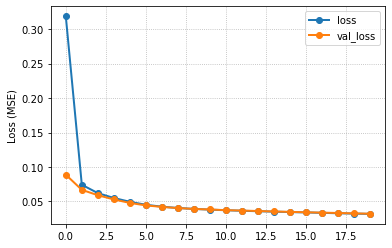

In [47]:
f, ax = plt.subplots()
pd.DataFrame(history.history).plot(ax=ax, lw=2, marker='o')
ax.grid(ls=':')
ax.set_ylabel('Loss (MSE)')

In [48]:
# %% reconstructed fields (first batch of the validation set)
preds = []
for i in range(data_val.batch_size):  
    X = data_val[0][0][i:i+1,:,:,:]
    pred = autoencoder.predict(X)
    preds.append(pred)

### Now plot comparison between reconstructed and original field (from the validation data)

Text(0.5, 1.0, 'reconstruction for instance N = 0')

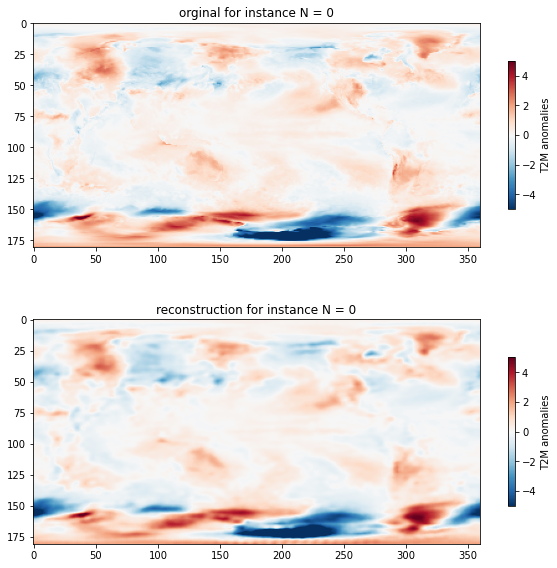

In [49]:
# choose the instance here 
i = 0

f, axes = plt.subplots(nrows=2, figsize=(10,10), subplot_kw={})

ax = axes[0]

im = ax.imshow(data_val[0][0][i,::-1,:,0].squeeze(), vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)

plt.colorbar(im, shrink=0.6, ax=ax, label='T2M anomalies')

ax.set_title(f"orginal for instance N = {i}")

ax = axes[1]

im = ax.imshow(preds[i].squeeze()[::-1,:], vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)

plt.colorbar(im, shrink=0.6, ax=ax, label='T2M anomalies')

ax.set_title(f"reconstruction for instance N = {i}")

### Now look at the reconstructions on the test test 

#### some data munging first to reshape and scale the test set 

In [50]:
dset_test[['t2m']]

<xarray.Dataset>
Dimensions:     (instance: 300, lat: 181, lon: 360)
Coordinates:
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    month       (instance) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    step        int64 3
  * instance    (instance) MultiIndex
  - time        (instance) datetime64[ns] 2016-01-01 2016-01-01 ... 2016-12-01
  - member      (instance) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
    surface     int64 0
    valid_time  (instance) datetime64[ns] dask.array<chunksize=(25,), meta=np.ndarray>
Data variables:
    t2m         (instance, lat, lon) float32 dask.array<chunksize=(25, 181, 360), meta=np.ndarray>

In [51]:
level =  xr.DataArray([1], coords={'level': [1]}, dims=['level'])

In [52]:
dset_test =  dset_test.expand_dims({'level': level}, -1)

In [53]:
dset_test

<xarray.Dataset>
Dimensions:     (instance: 300, lat: 181, level: 1, lon: 360)
Coordinates:
  * level       (level) int64 1
    month       (instance) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12
    step        int64 3
    surface     int64 0
    valid_time  (instance) datetime64[ns] dask.array<chunksize=(25,), meta=np.ndarray>
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * instance    (instance) MultiIndex
  - time        (instance) datetime64[ns] 2016-01-01 2016-01-01 ... 2016-12-01
  - member      (instance) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
Data variables:
    t2m         (instance, lat, lon, level) float32 dask.array<chunksize=(25, 181, 360, 1), meta=np.ndarray>

#### scale the test set 

In [54]:
dset_test = (dset_test * data_train.std) + data_train.mean

### Now predict for all instances in the test set 

In [55]:
preds = autoencoder.predict(dset_test['t2m'].load().data)

In [56]:
preds.shape

(300, 181, 360, 1)

### and add to the xarray dataset 

In [57]:
dset_test['reconstructed_t2m'] = (('instance','lat','lon', 'level'), preds)

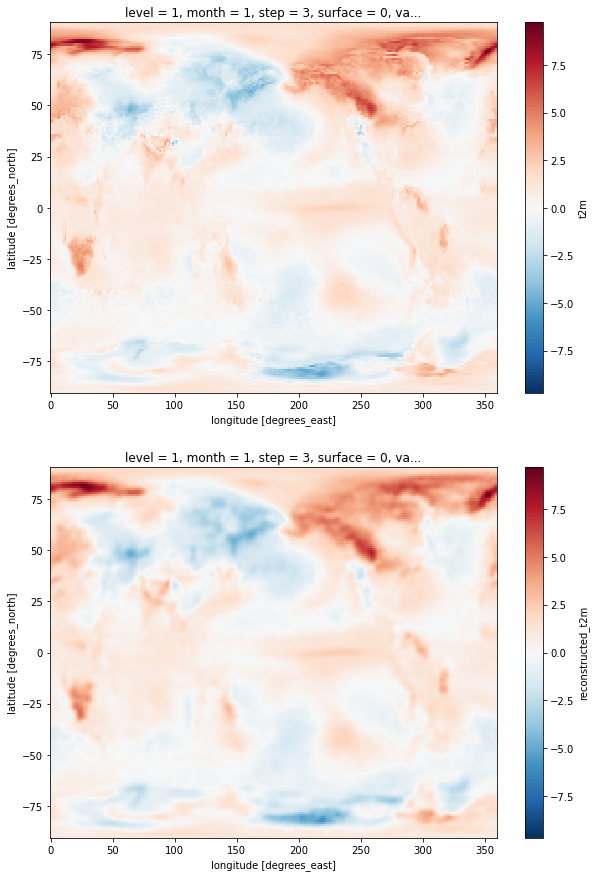

In [58]:
f, axes = plt.subplots(nrows=2, figsize=(10,15))

dset_test['t2m'].isel(instance=0).plot(ax=axes[0])

dset_test['reconstructed_t2m'].isel(instance=0).plot(ax=axes[1])

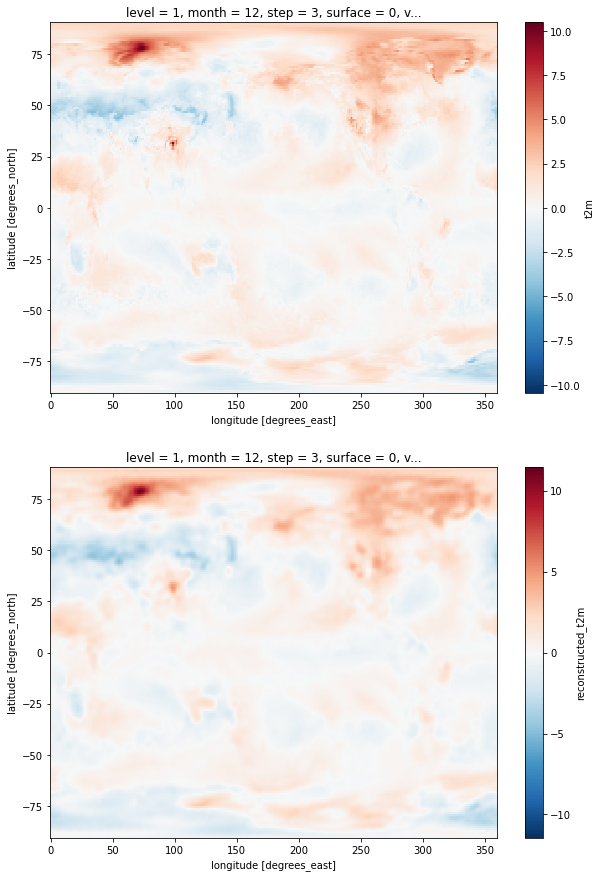

In [60]:
f, axes = plt.subplots(nrows=2, figsize=(10,15))

dset_test['t2m'].isel(instance=-1).plot(ax=axes[0])

dset_test['reconstructed_t2m'].isel(instance=-1).plot(ax=axes[1])